## Early Exiting Models: WideResNet

This Notebook contains the experiement process for building and evaluating early exiting models. 

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# sys.path.append("..") # Adds higher directory to python modules path.
sys.path.append("../..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate

### Model Determinism
If using Deterministic Operations, enable the following block to ensure that at each step the model begins with the same random seed. <br>
This is particularlly helpful to directly compare hyperparameter changes for small improvements without the need to repeat multiple tests to get average results.<br>
It is slightly slower but still fairly fast. <br>

In [3]:
_DETERMINISTIC = False
# _DETERMINISTIC = True

_SEED = 42
if _DETERMINISTIC: 
    import random
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    _SEED = 42

def reset_seeds(seed = _SEED):
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    

### Load datasets

Datasets are loaded in batches of 32, input sizes of (32,32) and shuffled between epochs. <br>
For Cifar datasets, The standard train and set sizes are used, with a separate 5k training images separated for validation set purposes.


In [4]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


Additionally the Noisy/OOD dataset is loaded in separately. by default CIFAR100 is used for the OOD dataset.

In [5]:
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


### From Scratch Model 

The code to load the pretrained ResNet50 model from keras servers.
If you already have a model, this step is unneccesary. 
<hr>

In [6]:
# # ### from scratch model
# base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(32, 32, 3),
#      weights='imagenet',include_top=False)


# x = base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

# model = tf.keras.models.Model(inputs=base_model.input, outputs=x)


# model.compile(optimizer='adam', 
#                 loss='categorical_crossentropy',
#                 metrics = ['accuracy'])

# model.summary()
# train_ds, test_ds, validation_ds = prepareDataset(32)
# EPOCHS = 3
# checkpoint = tf.keras.callbacks.ModelCheckpoint("models/resnet50_finetuned.hdf5", monitor='val_loss', verbose=1, mode='max')
# history = model.fit(train_ds, epochs=20, validation_data = validation_ds, batch_size=64,callbacks=[tensorboard_callback,checkpoint])

# loss, accuracy = model.evaluate(test_ds, batch_size=64)
# model.save("resnet50_finetuned.hdf5")




The model can be loaded like this:

In [7]:
# model = tf.keras.models.load_model("./models/resnet50_finetuned.hdf5")

In [8]:
# model.evaluate(test_ds)

### Branch designs
Defines the branch layer segments that will be added to the model in the brevis and branchynet models.

In [9]:
def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

## BranchyNet Model 
Build and train the branchnet version of the model. <br>
Branchynet uses the standard crossentropy loss function and softmax output classfication layers.
<hr>

In [12]:
tf.keras.backend.clear_session()
if _DETERMINISTIC:
    reset_seeds()
    
### setup hyperparameter growth controls.

# growth_callback = brevis.losses.growth_update(60, 0.,max_t = 1, starting_epoch =1) ### disabled for branchynet
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

### Loss functions 
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)

### Build the Model
model = brevis.BranchModel(name="./models/resnet50_finetuned.hdf5", custom_objects={})
model.add_branches(branchNames = [_branch_conv1,_branch_conv2],
                   branchPoints = ["conv2_block1_out","conv2_block3_out"], 
                   num_outputs=10
                  )

### Enable the training of the branches
model.setTrainable(True)

### Compile the model. Provide either a single loss or an individual loss for each exit.
model.compile(loss=[trunk_loss,CE_loss,CE_loss], 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                metrics=['accuracy'])

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core.BranchModel object at 0x00000148B4F92D48>
Freezing Main Layers and setting branch layers training to true


### Train the model and its newly added branches
<hr>

In [ ]:
model.fit(train_ds, validation_data=validation_ds, epochs = 1,callbacks=[#growth_callback
                                                                        ])

In [11]:
model.evaluate(test_ds)

313/313 [==============================] - 7s 22ms/step - loss: 2.4406 - classification_loss: 0.6301 - branch_exit_loss: 0.9454 - branch_exit_1_loss: 0.8651 - classification_accuracy: 0.7831 - branch_exit_accuracy: 0.6672 - branch_exit_1_accuracy: 0.7004


[2.4406206607818604,
 0.6300737857818604,
 0.9454376697540283,
 0.8651086091995239,
 0.7831000089645386,
 0.6672000288963318,
 0.7003999948501587]

### Evaluate BranchyNet Results
Next follow the below steps to evaluate the trained model to determine efficency improvement.
<hr>

#### 1. Cacluate Model Flops
This calculator uses the inbuilt Tensorflow operation measurement and estimates the flop usage for each classfication exit. <br>
Early exits are included in the calculation of later exits to represent the cost of evaluating at the earlier branch and then the output being rejected.

In [11]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    # print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS to reach classification exit: {temp_model.outputs[-1].name} : {flops / 10 ** 9:.03} G")

FLOPS to reach classification exit: branch_exit/BiasAdd:0 : 0.0271 G
FLOPS to reach classification exit: branch_exit_1/BiasAdd:0 : 0.0548 G
FLOPS to reach classification exit: classification/Softmax:0 : 0.186 G


#### 2. Calculate Thresholds

#### 3. Get Test Set Predictions

In [13]:

### specify the threshold_type that you want to evaluate the model on. Counter is based on batch size.
### process is slow when generating 'uncertanity' and 'entropy' so best practice is to disable these if not using them. 
output_ID= evaluate.getPredictions(model, test_ds,stopping_point=None, threshold_type =[#'energy', 
                                                                                'entropy',
                                                                                'uncertainty',
                                                                                'calibration',
                                                                               ], outlier = False)

outputs 3
evaluation values chosen:  ['energy']
True


In [16]:
output_OOD = evaluate.getPredictions(model, test_ds100,stopping_point=None, threshold_type =[#'energy', 
                                                                                'entropy',
                                                                                'uncertainty',
                                                                                'calibration',
                                                                               ],outlier = True)

outputs 3
evaluation values chosen:  ['energy']
True


#### 4. Evaluate Test Results

In [17]:
BranchyResults = evaluate.buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
# buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6672  -4.79835         5267          1976              4272           0.727185             0.589811
1     exit_2       4733        8024         0.7004 -4.678767         1322          1294              1003           0.505352             0.383410
2  Main_exit       3411        6730         0.7831        NA         3411          6730              2143           0.336357             0.211320


#### 5. Save the model

In [ ]:
model.save("./models/resnetBranched_branchyNet.hdf5")

## BrevisNet Model
Now that we've established a baseline using the branchynet model, the next step is to build and evaluate the BrevisNet version. <br>
This model will use a different loss function, enable the growth hyperparameter, and use "energy" as the evaluation value. 
<hr>

#### Build the model

In [ ]:
tf.keras.backend.clear_session()
if _DETERMINISTIC:
    reset_seeds()
### setup hyperparameter growth controls.
    ## always start growth >= 1 to allow the model at least one epoch to stabilise with just the basic loss.
growth_callback = brevis.losses.growth_update(annealing_rate = 60, starting_t = 0.,max_t = 1, starting_epoch =1, branch_names=["branch_exit_accuracy","branch_exit_1_accuracy"])
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

### Loss functions 
branch_loss = brevis.losses.IAD_loss(growth_callback)  ### the brevisnet loss function.
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False) ### the standard loss function for the main exit
# CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)

### Build the Model
model = brevis.BranchModel(name="./models/resnet50_finetuned.hdf5", custom_objects={})
model.add_branches(branchNames = [_branch_conv1,_branch_conv2],
                   branchPoints = ["conv2_block1_out","conv2_block3_out"], 
                   num_outputs=10
                  )
### Enable the training of the branches
model.setTrainable(True)

### Compile the model. Provide either a single loss or an individual loss for each exit.
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                metrics=['accuracy'])

#### Train the model and its newly added branches
<hr>

In [22]:
model.fit(train_ds, validation_data=validation_ds, epochs = 1,callbacks=[growth_callback])

Setting Main Layers  and branch layers training to true
0
annealing coef updated to: 0
1407/1407 [==============================] - 41s 27ms/step - loss: 2.2736 - classification_loss: 0.1499 - branch_exit_loss: 1.0562 - branch_exit_1_loss: 1.0675 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6325 - branch_exit_1_accuracy: 0.6282 - val_loss: 2.5874 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.8995 - val_branch_exit_1_loss: 0.9197 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.6900 - val_branch_exit_1_accuracy: 0.6926


In [ ]:
model.evaluate(test_ds)

### Evaluate BrevisNet Results
Next follow the below steps to evaluate the trained model to determine efficency improvement.
<hr>

#### 1. Cacluate Model Flops

In [ ]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    # print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS to reach classification exit: {temp_model.outputs[-1].name} : {flops / 10 ** 9:.03} G")

#### 2. Calculate Thresholds

#### 3. Get Test Set Predictions

In [ ]:
### specify the threshold_type that you want to evaluate the model on. Counter is based on batch size.
### process is slow when generating 'uncertanity' and 'entropy' so best practice is to disable these if not using them. 
output_ID= evaluate.getPredictions(model, test_ds,
                                   stopping_point=None, 
                                   threshold_type =['energy', 
                                                    # 'entropy',
                                                    # 'uncertainty',
                                                    # 'calibration',
                                                   ], outliers=False)

In [ ]:
output_OOD = evaluate.getPredictions(model, test_ds100,
                                     stopping_point=None,
                                     threshold_type =['energy', 
                                                    # 'entropy',
                                                    # 'uncertainty',
                                                    # 'calibration',
                                                   ], outliers=True)

#### 4. Evaluate Test Results

In [ ]:
BrevisResults = evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
# buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", main_exit_included=True,plot=False)

#### 5. Save the model

In [ ]:
model.save("./models/resnetBranched_brevisNet.hdf5")

### Compare Model Performances

In [ ]:
#BranchResults
#BrevisResults


In [131]:
#CE e25
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7576 -9.561772         5539          2048              4996           0.730065             0.658495
1     exit_2       4461        7952         0.7963 -5.523864         1853          1636              1578           0.531098             0.452279
2  Main_exit       2608        6316         0.7974        NA         2608          6316              1474           0.292246             0.165173


metric:  energy threshold:  gmean


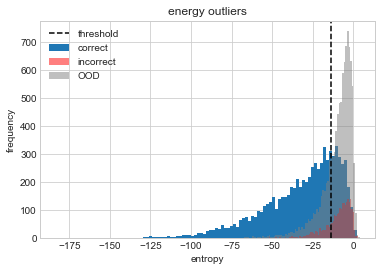

['exit_1', 'exit_2']


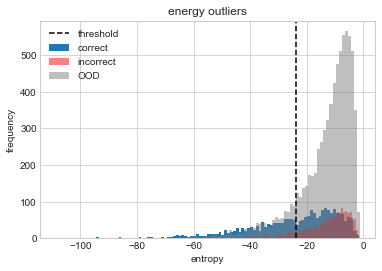

['exit_1', 'exit_2']


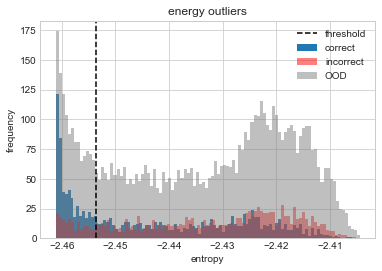

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7547 -13.877436         6168          2449              5576           0.715794             0.647093
1     exit_2       3832        7551         0.7773 -23.943192         1226          1002              1027           0.550269             0.460952
2  Main_exit       2606        6549         0.7815         NA         2606          6549              1346           0.284653             0.147023


In [123]:
#CE + EDL e15 g60
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

def buildComparePlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        print("m",metric)
                        AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct + accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


metric energy
energy  lr_auc 0.15226263522446273 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


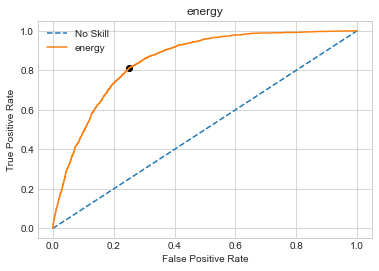

metric energy
energy  lr_auc 0.19527929359440427 Best Threshold=-78.74897766113281, G-Mean=0.7286457511152242, TPR=0.790765391014975, FPR=0.3285939968404423


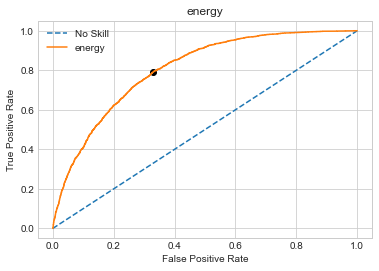

metric energy
energy  lr_auc 0.20056940097772982 Best Threshold=-76.37960815429688, G-Mean=0.7294623390321479, TPR=0.7907383136740935, FPR=0.3270652314874854


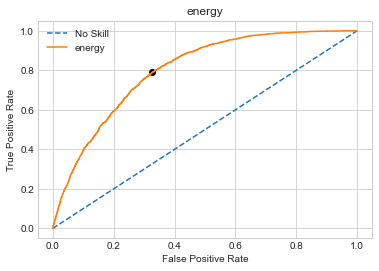

In [ ]:
for i in output_ID:
    calc_AUC(i, metrics=['energy'], plot = True)

In [53]:
### IAD with no info_reg
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["confidence_alea_uncert"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.6328433679660521 Best Threshold=-0.541270911693573, G-Mean=0.4119725361051053, TPR=0.32864820173625464, FPR=0.48357736446379107
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.6867825577407212 Best Threshold=-0.5967702865600586, G-Mean=0.37704360980545526, TPR=0.3256900212314225, FPR=0.5635055591890125
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7581 -0.541271         5540          7208              3915           0.434578             0.307107
1     exit_2       4460        2792         0.7645  -0.59677         1971          1820              1472           0.519916    

metric:  entropy threshold:  gmean
entropy  lr_auc 0.17137674861731156 Best Threshold=0.0496109202504158, G-Mean=0.7534711235280429, TPR=0.783003300330033, FPR=0.27494720168954595


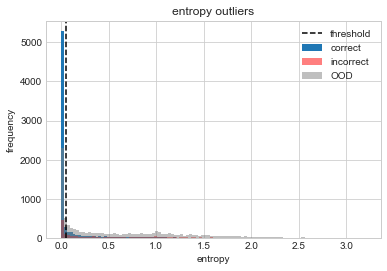

['exit_1', 'exit_2']
entropy  lr_auc 0.1578903434767735 Best Threshold=0.1522437334060669, G-Mean=0.7696279243226912, TPR=0.8247422680412371, FPR=0.28180334044957933


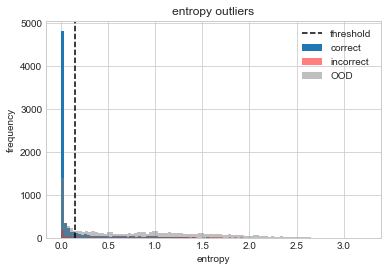

['exit_1', 'exit_2']
entropy  lr_auc 0.18006652172373638 Best Threshold=3.2170419692993164, G-Mean=0.7577669206415963, TPR=0.7502467917077986, FPR=0.2346375721093554


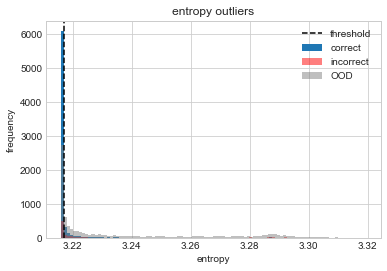

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7576  0.049611         6020          2606              5493           0.697890             0.636796
1     exit_2       3980        7394         0.7963  0.152244         1539          1543              1333           0.499351             0.432511
2  Main_exit       2441        5851         0.7974        NA         2441          5851              1349           0.294380             0.162687


In [53]:
#CE entroy epoch 25
buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=True)

metric:  expected_entropy threshold:  gmean
expected_entropy  lr_auc 0.8214007300281242 Best Threshold=-0.05152299104343559, G-Mean=0.7468468188567944, TPR=0.6969376979936642, FPR=0.19966996699669967


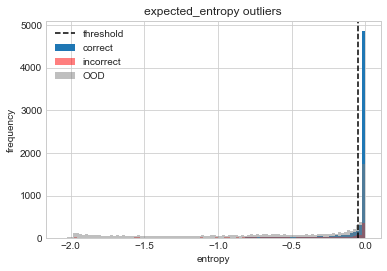

['exit_1', 'exit_2']
expected_entropy  lr_auc 0.8311578630942286 Best Threshold=-0.26161089535288395, G-Mean=0.761569944886436, TPR=0.6933316589225167, FPR=0.1634756995581738


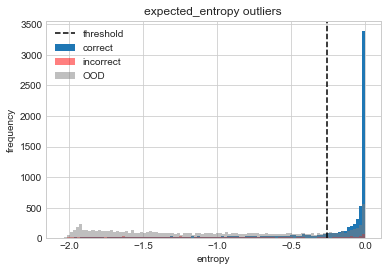

['exit_1', 'exit_2']
expected_entropy  lr_auc 0.8199329211843724 Best Threshold=-2.089558045285645, G-Mean=0.7577669206415963, TPR=0.7653624278906446, FPR=0.24975320829220138


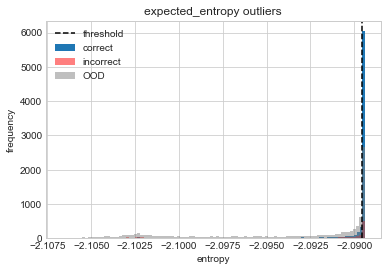

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7576 -0.051523         5764          2291              5280           0.715580             0.655493
1     exit_2       4236        7709         0.7963 -0.261611         1522          1272              1331           0.544739             0.476378
2  Main_exit       2714        6437         0.7974        NA         2714          6437              1537           0.296580             0.167960


In [51]:
### entropy 15epochs
buildCompareDistribPlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=True)

In [38]:
#### LR of 0.01, now with p=6

buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
buildCompareDistribPlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=False)
buildCompareDistribPlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean", main_exit_included=True,plot=False)
buildCompareDistribPlot(output_ID, output_OOD, ["confidence_alea_uncert"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
energy  lr_auc 0.5805526115131528 Best Threshold=-0.4993135929107666, G-Mean=0.45764345776277954, TPR=0.32285471537807986, FPR=0.35129479466387653
['exit_1', 'exit_2']
energy  lr_auc 0.60139981474915 Best Threshold=-0.6014286875724792, G-Mean=0.4400308717641781, TPR=0.4414145717937793, FPR=0.5613484907879263
['exit_1', 'exit_2']
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7646 -0.499314         6555          7528              4960           0.465455             0.352198
1     exit_2       3445        2472         0.7653 -0.601429         1394          1408              1000           0.497502             0.356888
2  Main_exit       2051        1064         0.7815  

In [22]:
def buildCompareDistribPlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metrics,plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct +accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


metric:  energy threshold:  gmean
energy  lr_auc 0.41995664901720187 Best Threshold=-0.543981671333313, G-Mean=0.5590818107126091, TPR=0.5270988310308182, FPR=0.40699456597464123


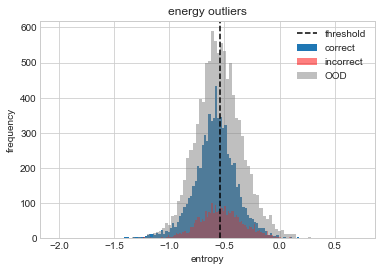

['exit_1', 'exit_2']
energy  lr_auc 0.5044758417768372 Best Threshold=-0.5112729668617249, G-Mean=0.499378722429568, TPR=0.37875974749350166, FPR=0.3415902559189818


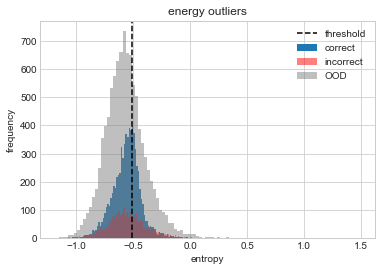

['exit_1', 'exit_2']
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


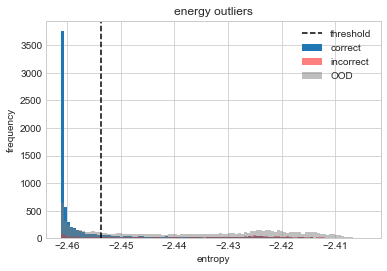

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7177 -0.543982         5592          5220              4256           0.517203             0.393637
1     exit_2       4408        4780         0.7307 -0.511273         2688          3013              1940           0.471496             0.340291
2  Main_exit       1720        1767         0.7815        NA         1720          1767              1316           0.493261             0.377402
metric:  expected_entropy threshold:  gmean
expected_entropy  lr_auc 0.8045929969446718 Best Threshold=-1.9398987163952157, G-Mean=0.7358578363382793, TPR=0.6995959314476801, FPR=0.22600070846617074


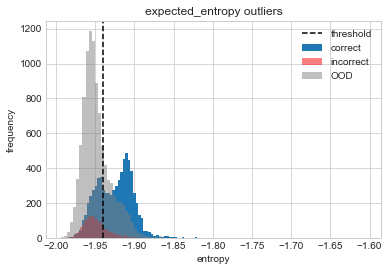

['exit_1', 'exit_2']
expected_entropy  lr_auc 0.8031119003386108 Best Threshold=-1.925632398485715, G-Mean=0.7474082024206364, TPR=0.6954974681811961, FPR=0.1968065354623097


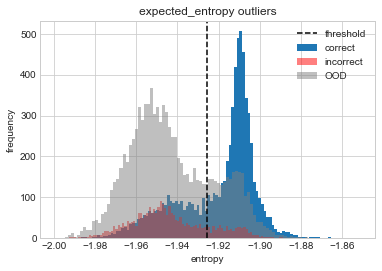

['exit_1', 'exit_2']
expected_entropy  lr_auc 0.8476093178786908 Best Threshold=-2.0921071332271106, G-Mean=0.7801595473378153, TPR=0.7488163787587971, FPR=0.18718535469107553


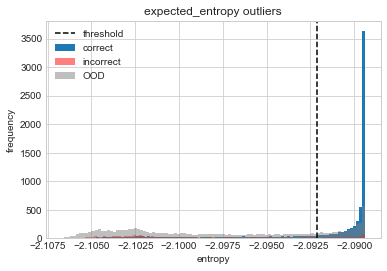

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7177 -1.939899         5659          2568              5021           0.687857             0.610308
1     exit_2       4341        7432         0.7307 -1.925632         1312          1246              1024           0.512901             0.400313
2  Main_exit       3029        6186         0.7815        NA         3029          6186              1762           0.328703             0.191210


In [29]:
#### LR of 0.001, seemingly the energy was really not diverging, but the entropy was... other thing I changed was increasing P to 6 from 4, 

buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)
buildCompareDistribPlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=True)

In [44]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'resnet_brevis_10_new'
save_outputs(filename+'_ID',output_ID)
save_outputs(filename+'_OOD',output_OOD)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

In [19]:
def calc_auc_OOD(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True, OOD_rate=[.1,.2,.5,1], plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for rate in OOD_rate:
                # print(int(min((len(_output_ID) * i),len(_output_ID))))
                print("OOD size",rate)
                _OOD_frac=[]
                Exit_Name=[]
                rollOver_ID_indices = pd.Index([])
                rollOver_OOD_indices = pd.Index([])
                Input_ID=[]
                Input_OOD=[]
                Accepted_list =[]
                Accepted_ID_list = []
                Accepted_OOD_list = []
                Acceptance_correct =[]
                Input_predictions =[]
                Accepted_Ratio_list=[]
                Accepted_Accuracy_list=[]
                # Branch_cost =[17443270,29419724,132134023] #flat exit costs
                # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

                # Base_cost = 112698838
                Branch_flops = []
                Thresholds=[]
                Test_accuracy =[]
                Rollover_accuracy=[]
                Results=[]
                for i, output in enumerate(_OOD):
                    
                    amount = min(len(_ID[i]) * rate,len(_ID[i]))
                    # print("len",amount)
                    _OOD_frac.append(_OOD[i].iloc[0:int(amount)])
                    # print(len(_OOD_frac[i]),len(_ID[i]))
                # _df = pd.concat([_ID,_OOD], ignore_index=True)
                # y_true = np.int32(_df['outlier'])
                for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD_frac)): 
                    Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))

                    legend = ["threshold","correct","incorrect", "OOD"]
                    Correct = output_ID.loc[(output_ID['correct'] == True)]
                    Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                    if plot:
                        _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                        _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                        _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram


                    if threshold:
                        if type(threshold) is list:
                            if j >= len(threshold): #no threshold in the array so treat as None.
                                continue
                            _threshold = threshold[j]
                        else:
                            _threshold = threshold
                        if _threshold == "mean":
                            # _threshold = np.array(ID[metric]).mean()
                            Correct = output_ID.loc[(output_ID["correct"] == True)]
                            _threshold = np.array(Correct[metric]).mean()
                        if _threshold == "gmean":
                            AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metrics,plot = False)
                            _threshold = AUC_thresholds[j]
                        if _threshold == "PR_AUC":
                            precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                            _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                        else:
                            _threshold = np.float32(_threshold)

                    if len(rollOver_ID_indices)>0:
                        # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                    if len(rollOver_OOD_indices)>0:
                        # if plot:
                        # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]

                    if plot:
                        plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                        plt.title(metric + " outliers")
                        plt.legend(legend)
                        plt.xlabel("entropy")
                        plt.ylabel("frequency")
                        plt.show()
                    if main_exit_included and i == len(_ID)-1 :
                        Exit_Name.append("Main_exit")
                        _threshold
                        if plot:
                            print("main_exit")
                        OOD_accepted = output_OOD
                        OOD_rejected = None
                        ID_accepted = output_ID
                        ID_rejected = None
                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = None
                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = None
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        _threshold = "NA"
                        ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                        # if metric in lessThanMetrics:
                            # _threshold = math.inf
                        # else:
                            # _threshold = -math.inf
                    # print(_threshold)
                    else:
                        if metric in lessThanMetrics: ## metrics that require less than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                        else: ### metrics that require greater than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                        rollOver_ID_indices = ID_rejected.index
                        rollOver_OOD_indices = OOD_rejected.index
                        if i >= len(exit_labels):
                            exit_labels.append("exit_{}".format(i+1))
                        print(exit_labels)
                        Exit_Name.append(exit_labels[i])
                    Thresholds.append(_threshold)

                    Results.append(accepted_correct +accepted_incorrect)
                    Input_ID.append(len(output_ID))
                    Input_OOD.append(len(output_OOD))
                    Accepted_ID_list.append(len(ID_accepted))
                    Accepted_OOD_list.append(len(OOD_accepted))
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                    Acceptance_correct.append(len(accepted_correct))
                    Accepted_Accuracy_list.append(overall_accepted_acc)
                df = pd.DataFrame({
                "Exit_Name":Exit_Name,
                "ID_Inputs":Input_ID,
                "OOD_Inputs":Input_OOD,
                "Test_Accuracy":Test_accuracy,
                # "RollOver_Accuracy":Rollover_accuracy,
                "Threshold":Thresholds,
                "Accepted ID":Accepted_ID_list,
                "Accepted OOD":Accepted_OOD_list,

                "Accepted_Correct":Acceptance_correct,
                "Accepted_ID_Ratio":Accepted_Ratio_list,
                "Acceptance_Accuracy":Accepted_Accuracy_list,

                # "Flops":Branch_flops,
                # "Cost Ratio":,                                  
                              })
                with pd.option_context('expand_frame_repr', False):
                    print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))


In [20]:
#entropy e15 not frozen
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  entropy threshold:  gmean
OOD size 0.1
entropy  lr_auc 0.17868656940254352 Best Threshold=3.218256950378418, G-Mean=0.7501293549804176, TPR=0.8018794048551292, FPR=0.2982809562181037
['exit_1']
entropy  lr_auc 0.15294470521800616 Best Threshold=3.2353153228759766, G-Mean=0.7733111525234805, TPR=0.8176100628930818, FPR=0.2685875996912786
['exit_1', 'exit_2']
entropy  lr_auc 0.16921497579585076 Best Threshold=3.2184739112854004, G-Mean=0.7616870657061426, TPR=0.8036465638148668, FPR=0.2780816689988551
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7446  3.218257         5732           248              5225           0.958528             0.873746
1     exit_2       4268         752         0.7774  3.235315         1641           136              1389           0.923467             0.781654
2  Main_exit       2627         616         0.78

In [25]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  energy threshold:  gmean
OOD size 0.1
energy  lr_auc 0.19527929359440427 Best Threshold=-78.74897766113281, G-Mean=0.7286457511152242, TPR=0.790765391014975, FPR=0.3285939968404423
['exit_1', 'exit_2']
energy  lr_auc 0.20056940097772982 Best Threshold=-76.37960815429688, G-Mean=0.7294623390321479, TPR=0.7907383136740935, FPR=0.3270652314874854
['exit_1', 'exit_2']
energy  lr_auc 0.15226263522446273 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7596 -78.748978         5604           196              5100           0.966207             0.879310
1     exit_2       4396         804         0.7711 -76.379608         1493            93              1217           0.941362             0.767339
2  Main_exit       2903         711   

In [32]:
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  entropy threshold:  gmean
OOD size 0.1
entropy  lr_auc 0.1710369520819908 Best Threshold=0.7144659161567688, G-Mean=0.758314919181238, TPR=0.8296468762126503, FPR=0.3068840091607167
['exit_1']
entropy  lr_auc 0.16184688699707256 Best Threshold=0.6023741364479065, G-Mean=0.7672922911561784, TPR=0.8150190920661858, FPR=0.2776396702865367
['exit_1', 'exit_2']
entropy  lr_auc 0.15235583743636819 Best Threshold=3.2306787967681885, G-Mean=0.7801595473378153, TPR=0.8128146453089244, FPR=0.2511836212412028
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7423  0.714466         5585           235              5145           0.959622             0.884021
1     exit_2       4415         765         0.7643  0.602374         1510           134              1242           0.918491             0.755474
2  Main_exit       2905         631         0.781

In [28]:
# print(output_ID.head())
# print(output_OOD_svhn.head())

In [29]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve

from matplotlib import pyplot
def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()
    return _thresholds




metric:  energy threshold:  gmean
energy  lr_auc 0.19554773669405584 Best Threshold=-36.46367263793945, G-Mean=0.7322403176176772, TPR=0.7958860759493671, FPR=0.3263157894736842
['exit_1']
5254 inputs accepted 4608 Correct


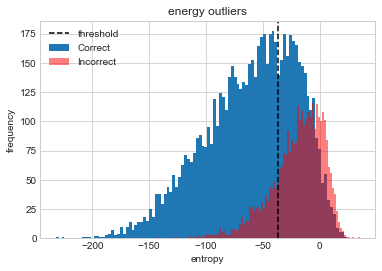

-----------------
energy  lr_auc 0.17401491388054582 Best Threshold=-36.54698181152344, G-Mean=0.7470667840621376, TPR=0.7621028744326778, FPR=0.2676726481783578
rollover enabled, 4746 predictions provided
['exit_1', 'exit_2']
1591 inputs accepted 1278 Correct


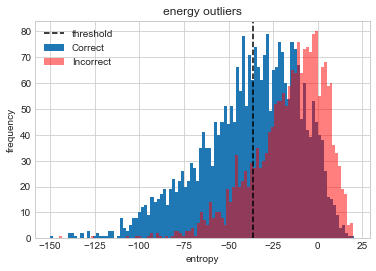

-----------------
energy  lr_auc 0.155865546303466 Best Threshold=-2.4609506130218506, G-Mean=0.7732734597462088, TPR=0.8307984790874525, FPR=0.28026849037487334
rollover enabled, 3155 predictions provided
main_exit
3155 inputs accepted 1861 Correct


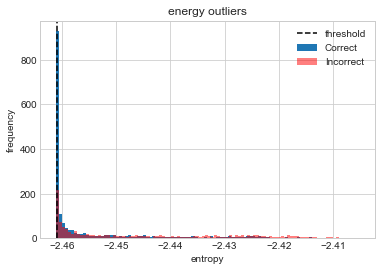

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6840           0.684000 -36.463673      5254              4608         0.52540             0.877046
1     exit_2         4746         0.7356           0.583439 -36.546982      1591              1278         0.33523             0.803268
2  Main_exit         3155         0.7896           0.589857  -2.460951      3155              1861         1.00000             0.589857


In [45]:
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=True)


In [19]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)


metric:  energy threshold:  PR_AUC
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6186           0.618600 -23.827610      3815              3233        0.381500             0.847444
1     exit_2         6185         0.6842           0.581568 -28.898783      1039               946        0.167987             0.910491
2  Main_exit         5146         0.7229           0.578119  -2.457023      5146              2975        1.000000             0.578119


In [46]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6840           0.684000 -62.067787      3161              2989        0.316100             0.945587
1     exit_2         6839         0.7356           0.638690 -85.762321       551               528        0.080567             0.958258
2  Main_exit         6288         0.7896           0.694338  -2.405045      6288              4366        1.000000             0.694338
metric:  energy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6840           0.684000 -60.051956      3304              3103        0.330400             0.939165
1     exit_2         6696       

metric:  uncert
4084 inputs accepted 3284 Correct


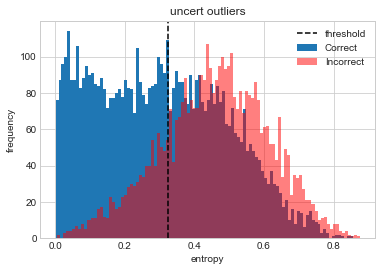

-----------------
rollover enabled, 5916 predictions provided
534 inputs accepted 500 Correct


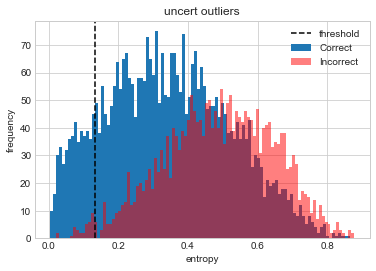

-----------------
rollover enabled, 5382 predictions provided
main_exit
5382 inputs accepted 3859 Correct


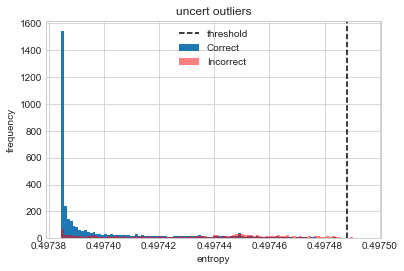

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy         Flops
0   branch1        10000         0.5917           0.591700   0.323077      4084              3284        0.408400             0.804114   71238314680
1   branch2         5916         0.7139           0.613083   0.134503       534               500        0.090264             0.936330   15710132616
2      main         5382         0.8091           0.717020   0.497488      5382              3859        1.000000             0.717020  711145311786
thresholds [0.32307744, 0.1345032, 0.4974882]
input_predictions [10000, 5916, 5382]
Accepted_list [4084, 534, 5382]
Acceptance_correct [3284, 500, 3859]
overall Accuracy 0.7643
branch_cost [71238314680, 15710132616, 711145311786]
base cost:  798093759082  total cost: 1126988380000
cost difference:  0.7081650292454656


In [34]:
calculateBranching(output_ID,threshold="PR_AUC",metrics=["uncert"],plot=)

energy  lr_auc 0.4420954222816514 Best Threshold=0.6266776323318481, G-Mean=0.5392735832037918, TPR=0.5870374968959523, FPR=0.5046040515653776
uncert  lr_auc 0.6111945439769917 Best Threshold=0.6424882411956787, G-Mean=0.4214332071208849, TPR=0.4315867891730817, FPR=0.58848150008371
entropy  lr_auc 0.23908319995230584 Best Threshold=1.1779698133468628, G-Mean=0.6944930195760037, TPR=0.7442264713185994, FPR=0.3519169596517663
calibration  lr_auc 0.767563131018646 Best Threshold=0.6875507235527039, G-Mean=0.7005592552981639, TPR=0.6845806127574083, FPR=0.28308914824931714


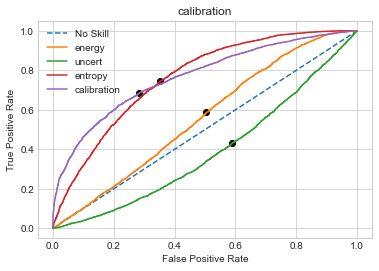

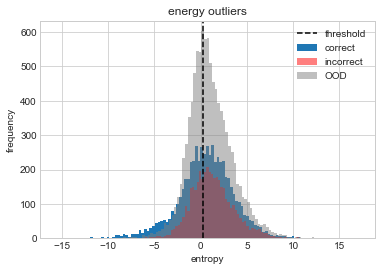

OOD accepted: 3935 : with threshold: 0.2630725
ID accepted: 4028 :with acc: 0.6519364448857994
overall Accepted acc: 0.32977521034785884
TPR_ID-OOD 0.4028
TPR_acc 0.43964506947932364
FPR_ID-OOD 0.3935
FPR_acc 0.3481499875838093


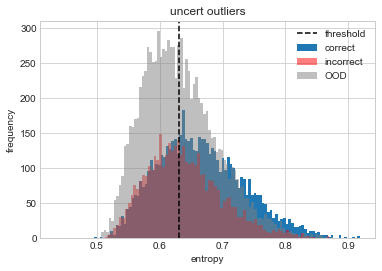

OOD accepted: 5368 : with threshold: 0.6314874
ID accepted: 4028 :with acc: 0.5034756703078451
overall Accepted acc: 0.21583652618135377
TPR_ID-OOD 0.4028
TPR_acc 0.33952787543947766
FPR_ID-OOD 0.5368
FPR_acc 0.4966476285075739


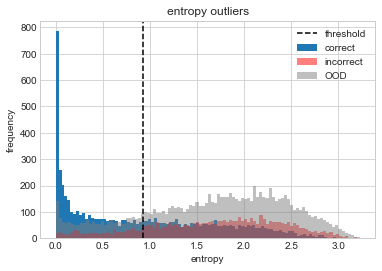

OOD accepted: 1908 : with threshold: 0.92764586
ID accepted: 4028 :with acc: 0.8331678252234359
overall Accepted acc: 0.5653638814016172
TPR_ID-OOD 0.4028
TPR_acc 0.5618617110329818
FPR_ID-OOD 0.1908
FPR_acc 0.16687360317854483


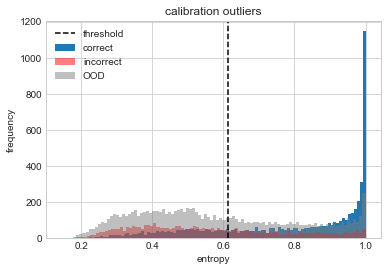

OOD accepted: 4024 : with threshold: 0.61402047
ID accepted: 5973 :with acc: 0.7461911937050059
overall Accepted acc: 0.4458337501250375
TPR_ID-OOD 0.5973
TPR_acc 0.7461911937050059
FPR_ID-OOD 0.4024
FPR_acc 0.376458902408741


In [ ]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "PR_AUC")

energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525
uncert  lr_auc 0.31638608086275255 Best Threshold=0.1802276074886322, G-Mean=0.62938448550687, TPR=0.6555429864253394, FPR=0.39573019801980197
entropy  lr_auc 0.2374392213330496 Best Threshold=0.00043300143443048, G-Mean=0.7017048641576846, TPR=0.7774321266968326, FPR=0.3666460396039604
calibration  lr_auc 0.7540569278930156 Best Threshold=0.9999741315841675, G-Mean=0.7015787824510725, TPR=0.6338180693069307, FPR=0.2234162895927602


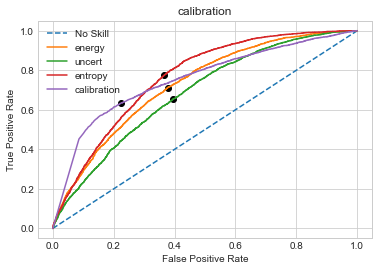

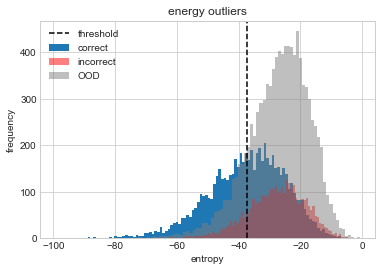

OOD accepted: 1480 : with threshold: -37.3288
ID accepted: 3575 :with acc: 0.8475524475524475
overall Accepted acc: 0.599406528189911
TPR_ID-OOD 0.3575
TPR_acc 0.46875
FPR_ID-OOD 0.148
FPR_acc 0.1541289592760181


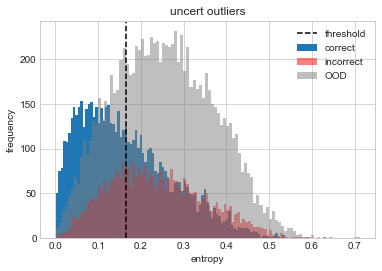

OOD accepted: 2543 : with threshold: 0.16586734
ID accepted: 4690 :with acc: 0.7742004264392324
overall Accepted acc: 0.5020047006774506
TPR_ID-OOD 0.469
TPR_acc 0.5617264851485149
FPR_ID-OOD 0.2543
FPR_acc 0.29949095022624433


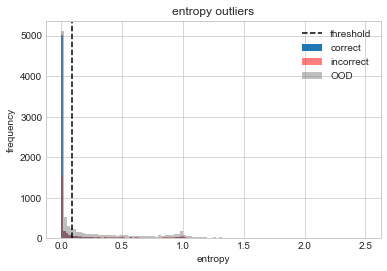

OOD accepted: 6098 : with threshold: 0.08850501
ID accepted: 7418 :with acc: 0.7314640064707468
overall Accepted acc: 0.4014501331754957
TPR_ID-OOD 0.7418
TPR_acc 0.8394183168316832
FPR_ID-OOD 0.6098
FPR_acc 0.5633484162895928


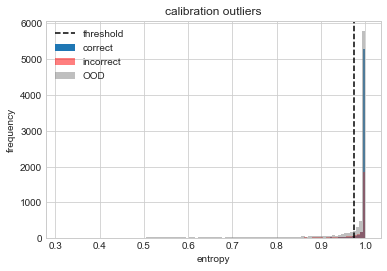

OOD accepted: 6723 : with threshold: 0.9752796
ID accepted: 7869 :with acc: 0.7158469945355191
overall Accepted acc: 0.3860334429824561
TPR_ID-OOD 0.7869
TPR_acc 0.8714418316831684
FPR_ID-OOD 0.6723
FPR_acc 0.6323529411764706


In [112]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

In [71]:
def combineThresholds(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        # if type(metrics ) is not list:
        #     metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")
        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID.loc[(ID[metric].tolist() <= energy_threshold)]
        _OOD = OOD.loc[(OOD[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold
        metric = 'energy'
        print("metric", metric)
        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((output_ID.loc[output_ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        _OOD_accepted = _OOD.loc[(_OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(_OOD_accepted))
        _ID_accepted = _ID.loc[(_ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(_ID_accepted))
        print("ID acc", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted))
        print("overall Acc (ID+OOD)", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]
        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", energy_threshold, ",", len(_OOD), ",", len(_ID),",",
                                                       len(_ID.loc[_ID['correct']==True])/len(_ID),",",
                                                       correct_threshold, ",",len(_OOD_accepted),",",
                                                       len(_ID_accepted),",", ",",
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted),',',
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
# combineThresholds(output_ID,output_OOD, metrics = ['energy'], excel=True)



def combineThresholds2(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        if type(metrics ) is not list:
            metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")

        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((ID.loc[ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        OOD_accepted = OOD.loc[(OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(OOD_accepted))
        ID_accepted = ID.loc[(ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(ID_accepted))
        print("ID acc", len(ID_accepted.loc[ID_accepted['correct'] == True])/len(ID_accepted))
        print("overall Acc (ID+OOD)", len(ID_accepted.loc[ID_accepted['correct'] == True])/(len(ID_accepted)+len(OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]


        metric  = 'energy'
        print("metric", metric)

        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID_accepted.loc[(ID_accepted[metric].tolist() <= energy_threshold)]
        _OOD = OOD_accepted.loc[(OOD_accepted[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold

        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", correct_threshold, ",", len(OOD_accepted), ",", len(ID_accepted),",",
                                                       len(ID_accepted.loc[ID_accepted['correct']==True])/len(ID_accepted),",",
                                                       energy_threshold, ",",len(_OOD),",",
                                                       len(_ID),",", ",",
                                                       len(_ID.loc[_ID['correct'] == True])/len(_ID),',',
                                                       len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
combineThresholds2(output_ID,output_OOD, metrics = ['energy'], excel=True)

 # df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,'entropy':Entropy,'calibration':calibration})

------ energy --------
threshold -49.350967
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
metric energy
-35.580128
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
energy , -49.350967 , 820 , 2952 , 0.9258130081300813 , -35.580128 , 820 , 2952 , , 0.9258130081300813 , 0.7245493107104984


In [36]:
###find 95% TPR
def buildTPR(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            _max =  np.array(ID[metric]).max()
            _min =  np.array(ID[metric]).min()
            linrange = np.linspace(_min, _max,100)
            print(len(linrange))
            total_correct = ID.loc[ID['correct'] == True]
            print(len(total_correct))
            # TP_qualifier = round(len(total_correct)*.95)
            TP_qualifier = round(len(ID)*.95)
            print("TP_qual",TP_qualifier)
            for point in linrange:
                # print(point)
                #get ID below this amount
                # TP = ID.loc[(ID[metric]<=point) & ID['correct'] == True]
                TP = ID.loc[(ID[metric]<=point) ]#& ID['correct'] == True]
                if len(TP) >=TP_qualifier:
                    FP = OOD.loc[(OOD[metric]<=point)]
                    print(point, "ID:", len(TP)," OOD:",len(FP))
            
            _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            # if threshold:
            #     if type(threshold) is list:
            #         if i >= len(threshold): #no threshold in the array so treat as None.
            #             continue
            #         _threshold = threshold[i]
            #     else:
            #         _threshold = threshold
            #     if _threshold == "mean":
            #         _threshold = np.array(ID[metric]).mean()
            #     print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
            #     print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
            #     print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
            #     Correct = ID.loc[(ID['correct'] == True)]
            #     # print(len(Correct))
            #     Incorrect = ID.loc[(ID['correct'] == False)]
            #     print("overall acc on ID:",len(Correct)/len(ID))

100
6217
TP_qual 9500
-1.2737780062839246 ID: 9503  OOD: 9160
-1.2017745176951093 ID: 9572  OOD: 9291
-1.1297710291062941 ID: 9651  OOD: 9426
-1.0577675405174798 ID: 9697  OOD: 9516
-0.9857640519286655 ID: 9746  OOD: 9597
-0.9137605633398502 ID: 9796  OOD: 9649
-0.841757074751035 ID: 9830  OOD: 9687
-0.7697535861622207 ID: 9858  OOD: 9734
-0.6977500975734063 ID: 9881  OOD: 9769
-0.6257466089845911 ID: 9901  OOD: 9800
-0.5537431203957759 ID: 9918  OOD: 9818
-0.48173963180696155 ID: 9933  OOD: 9838
-0.4097361432181472 ID: 9938  OOD: 9852
-0.337732654629332 ID: 9945  OOD: 9869
-0.2657291660405168 ID: 9950  OOD: 9880
-0.19372567745170244 ID: 9957  OOD: 9893
-0.1217221888628881 ID: 9962  OOD: 9909
-0.04971870027407288 ID: 9966  OOD: 9920
0.022284788314742343 ID: 9971  OOD: 9931
0.09428827690355668 ID: 9976  OOD: 9937
0.166291765492371 ID: 9980  OOD: 9946
0.23829525408118624 ID: 9983  OOD: 9953
0.31029874267000146 ID: 9985  OOD: 9954
0.3823022312588158 ID: 9987  OOD: 9960
0.45430571984763013

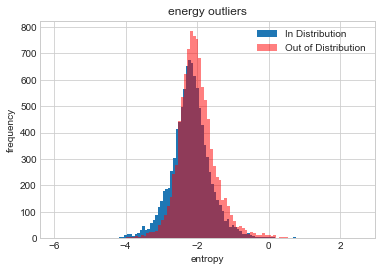

In [37]:
#crossEnergy
buildTPR(output_ID, output_OOD, ["energy"], "mean")

100
6408
TP_qual 9500
18.193120166508834 ID: 9663  OOD: 9363
22.363708650222918 ID: 9778  OOD: 9594
26.534297133937002 ID: 9868  OOD: 9744
30.704885617651144 ID: 9915  OOD: 9829
34.87547410136523 ID: 9945  OOD: 9885
39.04606258507931 ID: 9956  OOD: 9928
43.2166510687934 ID: 9966  OOD: 9955
47.38723955250748 ID: 9981  OOD: 9972
51.557828036221565 ID: 9986  OOD: 9981
55.728416519935706 ID: 9992  OOD: 9983
59.89900500364979 ID: 9995  OOD: 9988
64.06959348736387 ID: 9996  OOD: 9990
68.24018197107796 ID: 9998  OOD: 9994
72.41077045479204 ID: 9998  OOD: 9999
76.58135893850613 ID: 9998  OOD: 9999
80.75194742222027 ID: 9998  OOD: 10000
84.92253590593435 ID: 9999  OOD: 10000
89.09312438964844 ID: 10000  OOD: 10000


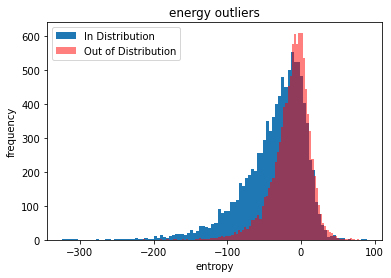

100
6408
TP_qual 9500
10.0 ID: 10000  OOD: 10000


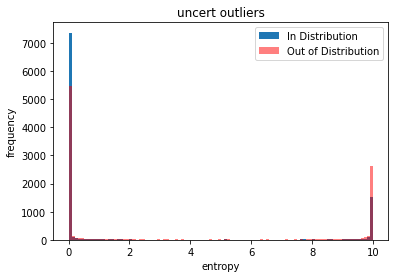

In [86]:
#EDL energy
buildTPR(output_ID, output_OOD, ["energy","uncert"], "mean")

In [88]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from matplotlib import pyplot
metrics = ['energy','entropy_of_expected']


def calc_aucpr(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = precision_recall_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, P={}, R={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        
        display = PrecisionRecallDisplay.from_predictions(y_test, output_df[metric], name="LinearSVC")
        _ = display.ax_.set_title("2-class Precision-Recall curve")
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy'],plot = True)
# print(threshold)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
precision_recall_fscore_support(output_ID['x'], output_ID['y'], average='macro')
# roc_auc_score(output_ID['correct'], output_ID['energy'])

(0.6464000000000001, 0.6490218675861255, 0.6450334719396431, None)

-37.470623
energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525


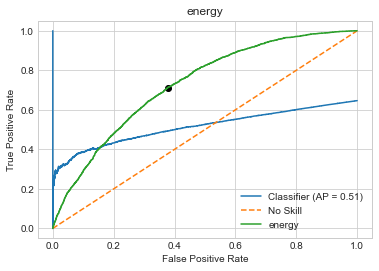

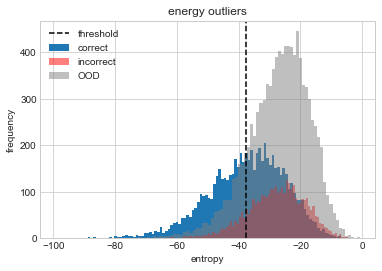

OOD accepted: 1447 : with threshold: -37.470623
ID accepted: 3537 :with acc: 0.8490245971162002
overall Accepted acc: 0.6025280898876404
TPR_ID-OOD 0.3537
TPR_acc 0.4645730198019802
FPR_ID-OOD 0.1447
FPR_acc 0.1510180995475113


In [104]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
y_test = output_ID['correct']
X_test = output_ID['energy']
precision_, recall_, proba = precision_recall_curve(y_test, X_test)

PrecisionRecallDisplay.from_predictions(output_ID['correct'], output_ID['energy'])

# PrecisionRecallDisplay(X_test, y_test)
# disp.ax_.set_title('Precision-Recall curve')

optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in X_test]
print(optimal_proba_cutoff)
# print(roc_predictions)
buildCompareDistribPlot(output_ID, output_OOD, ["energy"], optimal_proba_cutoff)

Best Threshold=-76.6483383178711, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=0.004616542719304562, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=3.495582809081781e-19, G-Mean=0.8007025231631392, P=1.0, R=0.35887546940018267
Best Threshold=0.3779428005218506, G-Mean=0.5945340142824697, P=1.0, R=0.6465293058611722


[]

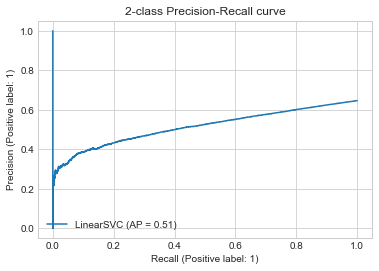

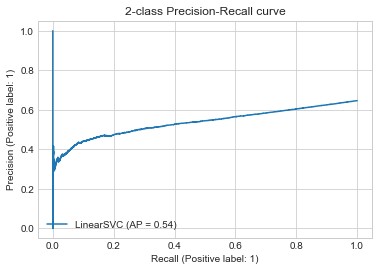

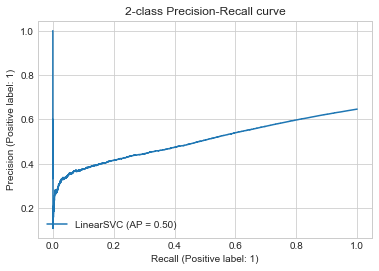

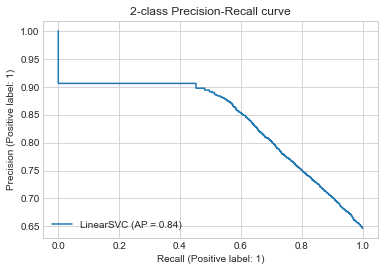

In [89]:
calc_aucpr(output_ID,metrics=["energy",'uncert','entropy','calibration'],plot=False)

max,min 1.0 0.36905995
0.3690599501132965 6464 3536
0.3754330819303339 6464 3535
0.38180621374737134 6463 3532
0.38817934556440875 6463 3531
0.39455247738144616 6463 3531
0.4009256091984835 6463 3528
0.407298741015521 6463 3526
0.41367187283255835 6463 3526
0.42004500464959577 6463 3524
0.4264181364666332 6463 3521
0.4327912682836706 6462 3517
0.439164400100708 6460 3517
0.4455375319177454 6460 3514
0.45191066373478284 6458 3513
0.45828379555182025 6458 3513
0.46465692736885766 6456 3509
0.471030059185895 6456 3506
0.4774031910029325 6456 3499
0.48377632281996985 6454 3495
0.49014945463700726 6452 3491
0.4965225864540447 6451 3488
0.502895718271082 6447 3481
0.5092688500881195 6438 3476
0.515641981905157 6435 3464
0.5220151137221943 6429 3452
0.5283882455392317 6425 3441
0.5347613773562692 6419 3430
0.5411345091733065 6415 3421
0.547507640990344 6411 3414
0.5538807728073813 6406 3406
0.5602539046244188 6401 3387
0.5666270364414562 6392 3379
0.5730001682584935 6385 3366
0.57937330007553

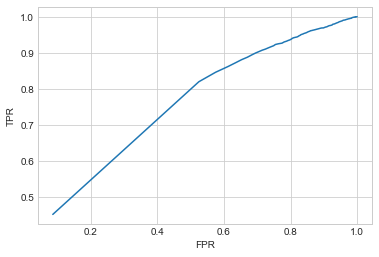

In [72]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot

def self_calc_AUC(output_df, metrics=['energy'], plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        #order the dataframe from lowest to highest
        df = output_df.sort_values(by=[metric,'correct'])
        t_max = df[metric].max()
        t_min = df[metric].min()
        print("max,min", t_max,t_min)
        #create a linspace
        linspace = np.linspace(t_min, t_max,num=100)
        Total_P = len(df.loc[df['correct']==True])
        Total_F = len(df.loc[df['correct']==False])
        TPR=[]
        FPR=[]
        for thresh in linspace:
            _outputs = df.loc[df[metric]>= thresh]
            correct = _outputs.loc[_outputs['correct']==True]
            incorrect = _outputs.loc[_outputs['correct']==False]
            print(thresh, len(correct), len(incorrect))
            _TPR = len(correct)/ Total_P
            _FPR = len(incorrect)/ Total_F
            TPR.append(_TPR)
            FPR.append(_FPR)
        # print(FPR)
        # print(TPR)
        pyplot.plot(FPR, TPR)
        pyplot.xlabel("FPR")
        pyplot.ylabel("TPR")
        pyplot.show()#     
# threshold = self_calc_AUC(output_ID, metrics=['energy'],plot = True)   
threshold = self_calc_AUC(output_ID, metrics=['calibration'],plot = True)   

energy  lr_auc 0.23328679452194093 Best Threshold=-48.40744400024414, G-Mean=0.7009286192837358, TPR=0.7452460850111857, FPR=0.3407534246575342


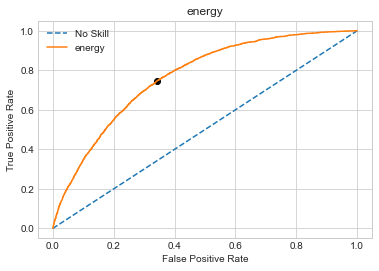

calibration  lr_auc 0.6673192808846022 Best Threshold=1.0, G-Mean=0.638403421479321, TPR=0.8429327521793275, FPR=0.5164988814317674


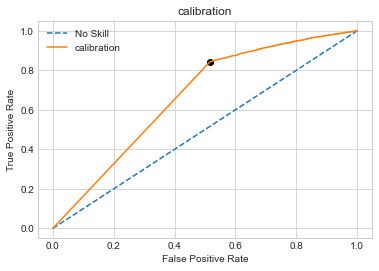

In [61]:
threshold = calc_AUC(output_ID, metrics=["energy"],plot = True)
threshold = calc_AUC(output_ID, metrics=["calibration"],plot = True)

In [41]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot
# metrics = ['energy','entropy_of_expected']


def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

#         accepted = output_df.loc[output_df[metric] <= threshold]
#         y_test_accept = np.int32(accepted['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted[metric])
#         print(len(thresholds))
#         print("lr_auc_accepted",lr_auc)

#         threshold2 = np.array(output_df.loc[output_df['correct']==True][metric]).mean()
#         accepted2 = output_df.loc[output_df[metric] <= threshold2]
#         y_test_accept = np.int32(accepted2['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted2[metric])
#         print("lr_auc_accepted2",lr_auc)



#         print(len(accepted), len(accepted.loc[(accepted['correct'] == True)]))
#         _ = pyplot.hist(output_df[metric].tolist(), bins=100,alpha=0.5)  # arguments are passed to np.histogram
#         _ = pyplot.hist(output_df.loc[(output_df['correct'] == True)][metric].tolist(), bins=100)  # arguments are passed to np.histogram
#         plt.axvline(x=threshold, color='k', linestyle='--',label="threshold")
#         pyplot.show()
            
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)


# print(threshold)

energy  lr_auc 0.23581525312294546 Best Threshold=-65.02085876464844, G-Mean=0.6930189181980165, TPR=0.7151234567901235, FPR=0.32840236686390534
entropy  lr_auc 0.21818394331214847 Best Threshold=7.617240171953199e-10, G-Mean=0.7112415642998093, TPR=0.7209876543209877, FPR=0.29837278106508874
uncert  lr_auc 0.2504219857184601 Best Threshold=0.01307495404034853, G-Mean=0.6874553625126794, TPR=0.6984567901234567, FPR=0.32337278106508877
confidence_alea_uncert  lr_auc 0.6952099998173716 Best Threshold=1.0, G-Mean=0.679469876950052, TPR=0.7714497041420119, FPR=0.4015432098765432
entropy_of_expected  lr_auc 0.7661175031046826 Best Threshold=-3.731665636471849e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
expected_entropy  lr_auc 0.7663178921031485 Best Threshold=-3.909963365774104e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
calibration  lr_auc 0.6932918310322156 Best Threshold=1.0, G-Mean=0.6743145587834388, TPR=0.797633136

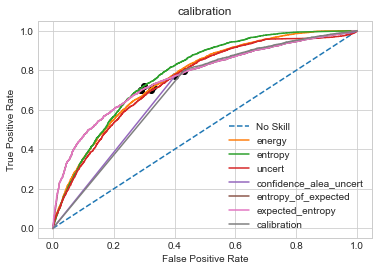

In [42]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)

energy  lr_auc 0.30746509020901197 Best Threshold=-12.230971336364746, G-Mean=0.6447222206555288, TPR=0.6918058455114823, FPR=0.39915693904020755
entropy  lr_auc 0.23931991909214234 Best Threshold=0.7835158109664917, G-Mean=0.6983915306471645, TPR=0.759133611691023, FPR=0.35749027237354086
uncert  lr_auc 0.35281864661435275 Best Threshold=0.3646439015865326, G-Mean=0.6121356188521229, TPR=0.6072546972860126, FPR=0.3829442282749676
confidence_alea_uncert  lr_auc 0.7616135598848119 Best Threshold=0.832136869430542, G-Mean=0.6976568205033336, TPR=0.6507782101167315, FPR=0.2520876826722338
entropy_of_expected  lr_auc 0.7578205598157641 Best Threshold=-0.5445331625295522, G-Mean=0.6981025938832756, TPR=0.6371595330739299, FPR=0.23512526096033404
expected_entropy  lr_auc 0.7583946471653817 Best Threshold=-0.540065626234581, G-Mean=0.6982834773852532, TPR=0.6355382619974059, FPR=0.23277661795407098
calibration  lr_auc 0.7630961428979526 Best Threshold=0.8225886821746826, G-Mean=0.697887108646

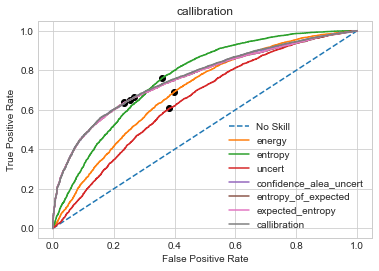

In [17]:
# threshold = calc_AUC(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#MAEB

lr_auc 0.29612755195940693
Best Threshold=-7.480616569519043, G-Mean=0.6498070813025146, TPR=0.7059282371294852, FPR=0.4018524536886578
lr_auc 0.24005162351440434
Best Threshold=0.9972052574157715, G-Mean=0.6950418578983907, TPR=0.7927717108684348, FPR=0.39064023399415015
lr_auc 0.37206364432672856
Best Threshold=0.44796812534332275, G-Mean=0.5952901008407016, TPR=0.6315652626105044, FPR=0.43890152746181343
lr_auc 0.7651199808148321
Best Threshold=0.7181436419487, G-Mean=0.7008415143051968, TPR=0.6670458238544036, FPR=0.26365054602184085
lr_auc 0.7568078446244773
Best Threshold=-0.8272647119808325, G-Mean=0.6919269077521468, TPR=0.6494962625934352, FPR=0.2628705148205928
lr_auc 0.7574571523647426
Best Threshold=-0.8330044417222909, G-Mean=0.6924701182740562, TPR=0.6542086447838804, FPR=0.2670306812272491
lr_auc 0.7660429881608655
Best Threshold=0.7298916578292847, G-Mean=0.7018544841976537, TPR=0.6711082222944427, FPR=0.265990639625585


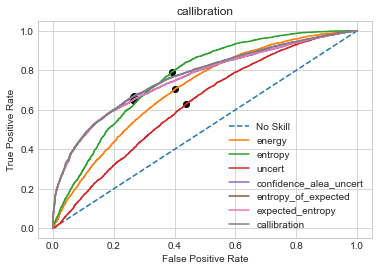

In [82]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#EDL

OOD size 10000
lr_auc 0.656151925
Best Threshold=-21.352628707885742, G-Mean=0.3962403815867333, TPR=0.3394, FPR=0.5374
lr_auc 0.65798663
Best Threshold=1.6821411918499507e-05, G-Mean=0.39619328616219635, TPR=0.3472, FPR=0.5479
lr_auc 0.644239215
Best Threshold=0.4506461024284363, G-Mean=0.4022347076024147, TPR=0.3214, FPR=0.4966
lr_auc 0.37535799999999997
Best Threshold=0.9999980926513672, G-Mean=0.3929694644625712, TPR=0.426, FPR=0.6375
lr_auc 0.34221492
Best Threshold=-3.639874760966167e-05, G-Mean=0.3932804088687866, TPR=0.4324, FPR=0.6423
lr_auc 0.34184017
Best Threshold=-3.848563147968418e-05, G-Mean=0.393089760741742, TPR=0.4338, FPR=0.6438
lr_auc 0.38505431
Best Threshold=0.9999992847442627, G-Mean=0.3960258829925135, TPR=0.4525, FPR=0.6534


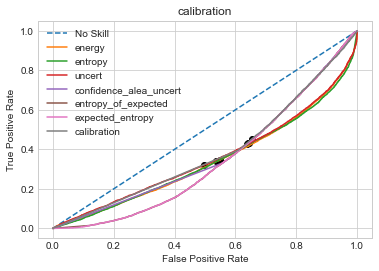

In [121]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
# metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
# metrics =['energy','uncert','expected_entropy','calibration']

metrics = ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
def calc_auc_OOD(ID,OOD,metrics=['energy'],OOD_rate=[.1,.2,.5,1], plot=False):
    points = []
    # OOD_rate = [0,.1,.2,.5,1]
    _output_ID = ID
    _output_OOD = OOD

    _output_ID["outlier"]=0
    _output_OOD["outlier"]=1
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    for i in OOD_rate:
        # print(int(min((len(_output_ID) * i),len(_output_ID))))
        _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
        print("OOD size",len(_OOD))
        _df = pd.concat([_output_ID,_OOD], ignore_index=True)
        y_true = np.int32(_df['outlier'])

    #     print(len(_df))
    #     for metric in metrics:
    #         points.append([])
    #         # print(metric, ":", average_precision_score(y_true, _df[metric]))

    #         Correct = _df.loc[(_df['correct'] == True)]
    #         Incorrect = _df.loc[(_df['correct'] == False)]
    #         fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
    #         gmeans = sqrt(tpr * (1-fpr))
    #         ix = argmax(gmeans)
    #         _threshold = thresholds[ix]
    #         # _threshold = np.array(Correct[metric]).mean()
        plots = []
        for metric in metrics:    
            lr_auc = roc_auc_score(y_true, _df[metric])
            print("lr_auc",lr_auc)
            if metric in lessThanMetrics:
                pos_label = 0
            else:
                pos_label = 1
            fpr, tpr, thresholds = roc_curve(y_true, _df[metric],pos_label=pos_label)
            gmeans = sqrt(tpr * (1-fpr))
            # print(gmeans)
            # locate the index of the largest g-mean
            ix = argmax(gmeans)
            threshold = thresholds[ix]
            print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
            _thresholds.append(threshold)
            # plot the roc curve for the model
            plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
        # if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

# calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       

calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       

# def calc_gmeans(output_df,metrics=['energy'],plot=False):
#     lessThanMetrics = ["energy","uncert","entropy"]
#     _thresholds = []
    
#     y_test = np.int32(output_df['correct'])
#     plots = []
#     for metric in metrics:    
#         lr_auc = roc_auc_score(y_test, output_df[metric])
#         print("lr_auc",lr_auc)
#         if metric in lessThanMetrics:
#             pos_label = 0
#         else:
#             pos_label = 1
#         fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
#         gmeans = sqrt(tpr * (1-fpr))
#         # print(gmeans)
#         # locate the index of the largest g-mean
#         ix = argmax(gmeans)
#         threshold = thresholds[ix]
#         print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
#         _thresholds.append(threshold)
#         # plot the roc curve for the model
#         plots.append({"fpr":fpr,"tpr":tpr,"label":"metric", "ix":ix})
#     if plot:
#         pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         for plot in plots:
#             ix = plot['ix']
#             pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

#             pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
#         # axis labels
#         pyplot.xlabel('False Positive Rate')
#         pyplot.ylabel('True Positive Rate')
#         pyplot.title(metric)
#         pyplot.legend()
#         # show the plot
#         pyplot.show()
        

10000
lr_auc 0.17632298999999999
Best Threshold=-5.625901222229004, G-Mean=0.7577538320589345, TPR=0.7897, FPR=0.2729
lr_auc 0.163048365
Best Threshold=1.7985261678695679, G-Mean=0.7553904420893873, TPR=0.7592, FPR=0.2484
lr_auc 0.26289053
Best Threshold=0.45931094884872437, G-Mean=0.6940969240675253, TPR=0.7773, FPR=0.3802
lr_auc 0.83095955
Best Threshold=0.49477264285087585, G-Mean=0.7527356375248883, TPR=0.7481, FPR=0.2426
lr_auc 0.8377772299999999
Best Threshold=-1.3245874584253854, G-Mean=0.7618700217228658, TPR=0.7367, FPR=0.2121
lr_auc 0.83854707
Best Threshold=-1.3036969119965915, G-Mean=0.7614107432916875, TPR=0.7346, FPR=0.2108
lr_auc 0.8264950799999999
Best Threshold=0.5462754368782043, G-Mean=0.7462074711499478, TPR=0.7087, FPR=0.2143


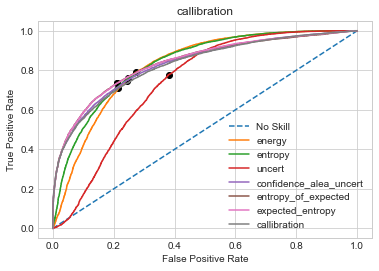

10000
lr_auc 0.3541886000000001
Best Threshold=-6.632209777832031, G-Mean=0.6040072847242821, TPR=0.6247, FPR=0.416
lr_auc 0.33489378000000003
Best Threshold=1.3389952182769775, G-Mean=0.6181435512888571, TPR=0.6535, FPR=0.4153
lr_auc 0.41053229999999996
Best Threshold=0.45440253615379333, G-Mean=0.5676407754909789, TPR=0.5759, FPR=0.4405
lr_auc 0.6552974600000001
Best Threshold=0.6583983302116394, G-Mean=0.6085316014801532, TPR=0.5677, FPR=0.3477
lr_auc 0.6647074949999999
Best Threshold=-1.0051595671170843, G-Mean=0.6170466676030266, TPR=0.5873, FPR=0.3517
lr_auc 0.6649351350000001
Best Threshold=-0.9957128697464878, G-Mean=0.6170181682900431, TPR=0.5858, FPR=0.3501
lr_auc 0.652951265
Best Threshold=0.7174296975135803, G-Mean=0.6068091627521787, TPR=0.5292, FPR=0.3042


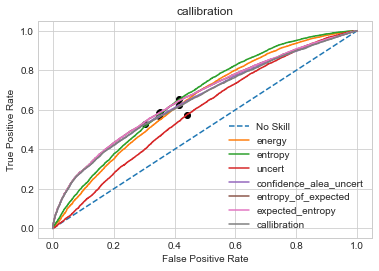

In [81]:
calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       


calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       

In [46]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
metrics =["energy","entropy","calibration"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=0
_output_OOD["outlier"]=1
lessThanMetrics = ["energy","uncert","entropy"]
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # print(metric, ":", average_precision_score(y_true, _df[metric]))
        
        Correct = _df.loc[(_df['correct'] == True)]
        Incorrect = _df.loc[(_df['correct'] == False)]
        fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)
        _threshold = thresholds[ix]
        # _threshold = np.array(Correct[metric]).mean()
        if metric in lessThanMetrics:
            accepted = _df.loc[(_df[metric] <= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)]
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN
            # print(metric, ":", len(Correct)/len(_df), "accepted_acc", len(accepted_correct)/len(accepted))
        else:
            accepted = _df.loc[(_df[metric] >= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)] #TP
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN
        try:
            ODD_accept = len(accepted_OOD)/len(_OOD)
        except:
            ODD_accept ="NAN"
        np.seterr(invalid='ignore')
        AUC_PR_OOD = average_precision_score(np.int32(accepted['outlier']), accepted[metric])
        AUC_ROC = roc_auc_score(np.int32(accepted['correct']), accepted[metric])
        AUC_PR = average_precision_score(np.int32(accepted['correct']), accepted[metric])
        FPR = len(accepted_incorrect) / (len(accepted_incorrect) + len(rejected_incorrect))
        print(metric,":",len(accepted_ID)/len(_output_ID),":",ODD_accept, ":", len(accepted_correct)/len(accepted), ":FPR:",FPR,":AUC_PR(T/F):",AUC_PR,":AUC_ROC:",AUC_ROC)


0
10000
energy : 0.5996 : NAN : 0.7198132088058706 :FPR: 0.4384133611691023 :AUC_PR(T/F): 0.6245638987195575 :AUC_ROC: 0.3303461097135796
entropy : 0.5763 : NAN : 0.7666146104459483 :FPR: 0.3509916492693111 :AUC_PR(T/F): 0.6477462359394405 :AUC_ROC: 0.25846595795167115
calibration : 0.5131 : NAN : 0.7998440849736893 :FPR: 0.2680062630480167 :AUC_PR(T/F): 0.9133633355608572 :AUC_ROC: 0.7249858119278505
1000
11000
energy : 0.5996 : 0.412 : 0.6735330836454432 :FPR: 0.4329470198675497 :AUC_PR(T/F): 0.5706115701137225 :AUC_ROC: 0.32503273869119664
entropy : 0.5763 : 0.344 : 0.7234321270672999 :FPR: 0.34954470198675497 :AUC_PR(T/F): 0.5999034689406928 :AUC_ROC: 0.26439191519916505
calibration : 0.5131 : 0.288 : 0.7573353017161838 :FPR: 0.2721440397350993 :AUC_PR(T/F): 0.8915049540682882 :AUC_ROC: 0.7213421571461396
2000
12000
energy : 0.5996 : 0.409 : 0.6334018197828001 :FPR: 0.4283264746227709 :AUC_PR(T/F): 0.5270595868474839 :AUC_ROC: 0.3237112396126354
entropy : 0.5763 : 0.342 : 0.6852799

0
10000
Best Threshold=-1.9426160284718987, G-Mean=0.82936722867497, Recall=1.0, Precision=0.37573757375737576


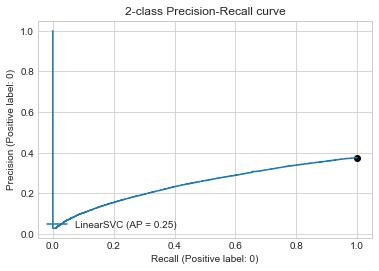

1000
11000
Best Threshold=-1.9430203248942899, G-Mean=0.82936722867497, Recall=1.0, Precision=0.4324545454545455


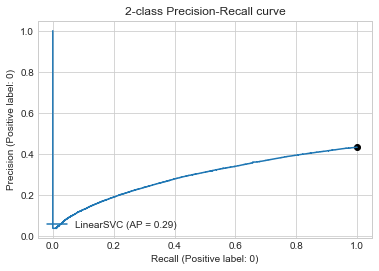

2000
12000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.47975


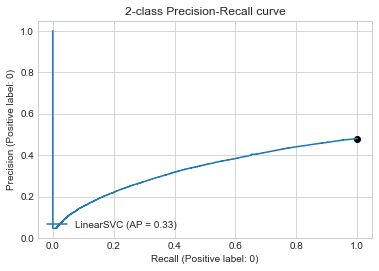

5000
15000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.5838


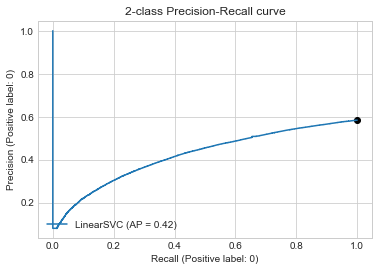

10000
20000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.68785


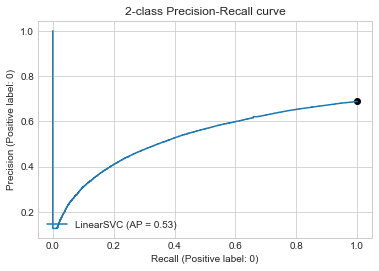

In [256]:
from sklearn.metrics import average_precision_score

metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"]
metrics =["expected_entropy"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=1
_output_OOD["outlier"]=0
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # calc_aucpr(_df,plot=True)
        precision, recall, thresholds = precision_recall_curve(np.int32(_df['correct']), _df[metric],pos_label =0)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, Recall={}, Precision={}'.format(threshold, gmeans[ix],recall[ix],precision[ix]))
        
        display = PrecisionRecallDisplay.from_predictions( np.int32(_df['correct']), _df[metric], name="LinearSVC",pos_label =0 )
        _ = display.ax_.set_title("2-class Precision-Recall curve") 
        pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        plt.show()
        # Correct = _df.loc[(_df['correct'] == True)]
        # Incorrect = _df.loc[(_df['correct'] == False)]
        # print(metric, ":", len(Correct)/len(_df))

        


In [ ]:
def buildOutlierPlot_multi(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]

                percents.append(percent/2)
                accuracy.append(len(Correct) / total_inputs)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("outliers")
        plt.legend(metrics)
        plt.xlabel("Outlier percentage")
        plt.ylabel("Accuracy")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

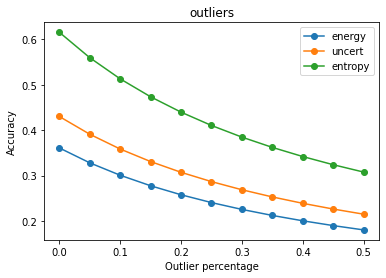

In [20]:
multiplot = buildOutlierPlot_multi(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [36]:
def buildOutlierPlot_AUC(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                #x =  false positive / sum(false positive + True Negative)
                # that thresholded are negative, so ID thresh is FN, OOD thresh is TN
                TP =  ID.loc[ID[metric]<=_threshold] #ID that are accepted 
                TN = _OOD.loc[_OOD[metric]>_threshold] #OOD that are not accepted 
                FN =  _OOD.loc[_OOD[metric]<=_threshold] #ID that are accepted 
                FP =  ID.loc[ID[metric]>_threshold] #ID that are accepted 
                
                _TP = len(TP)
                _TN = len(TN)
                _FN = len(FN)
                _FP = len(FP)
                
                # print("TP", len(TP), "TN",len(TN),"FN",len(FN),"FP",len(FP))
                x = _FP/ (_FP + _TN)
                
                y = _TP/(_TP+_FN)
                
                print(x,y)
                percents.append(x)
                accuracy.append(y)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("AUC OOD")
        plt.legend(legend)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

1.0 1.0
0.8737792246226694 0.9656723484848485
0.7777924130663857 0.9295806745670009
0.699893327011971 0.8980625275209159
0.6356297093649085 0.8702794964796245
0.5818307222386442 0.8450383260824529
0.5384825825278132 0.8144968051118211
0.4997461069735951 0.7911171450737006
0.4664296998420221 0.7680286198456034
0.43747221810638615 0.7455675379272528
0.4119575833682154 0.7239971600993965
1.0 1.0
0.8673469387755102 0.9523721275018532
0.7658868163136263 0.9089140431552883
0.6846121237812632 0.8707217892239919
0.618379068283344 0.8366981439270595
0.5639622861133745 0.8048551292090838
0.5199055692670888 0.7722013523666417
0.4803212055120452 0.74640522875817
0.4472858197932053 0.7198487183078862
0.41832153341391815 0.6956816028157574
0.3937423811458757 0.6706250815607464
1.0 1.0
0.849329205366357 0.9149106161989414
0.7421100090171325 0.8427007634992181
0.6495659037095501 0.7821892076502732
0.5857651245551602 0.7286827871460388
0.5323415265200517 0.6821295606850335
0.4852594339622642 0.64161647

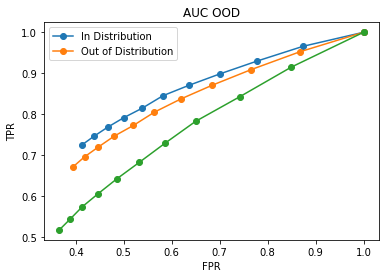

In [37]:
multiplot = buildOutlierPlot_AUC(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")